Mini-projet : Interpolation de Données Manquantes
==============================

*Contexte* : dans le cadre d'acquisition de données sismiques, des capteurs (récepteurs) sont positionnés le long d'une ligne à la surface de la terre. Chacun enregistre au cours du temps le déplacement des particules (signal oscillant) qui varie lors du passage d'une onde acoustique ou élastique. Cet enregistrement s'appelle une **trace**. Chaque trace correspond à une *colonne* de l'image presentée au début de la section 2 (une seule position spatiale, un signal qui dépend du temps).

En pratique, il arrive que certains capteurs sont défaillants ou encore qu'ils ne sont pas présents dans certaines zones (pour des problèmes d'accessibilité par exemple). L'objectif principal du mini-projet est de reconstituer les traces manquantes.

*Hypothèses* : nous ferons l'hypothèse importante que les **signaux d'une trace peuvent être *localement* prédits à partir d'une trace voisine, par un simple décalage temporel** (voir la partie "Première Analyse" pour une définition précise). 

*Notions abordées* : 
* Analyse des signaux dans le domain d'origine ;
* Analyse des signaux après transformée de Fourier 2d ;
* Régularisation et formulation sous forme de problème inverse.

Pour cela, trois approches sont considerées :
* *Approche 1* : analyse dans le domaine $(x,t)$ : identification de 3 temps et de 3 pentes, sélection d'une ondelette source, prédiction des données manquantes ;
* *Approche 2* : transformée de Fourier 2d, identification des événements principaux, définition d'un masque et reconstitution des traces manquantes ;
* *Approche 3* (optionelle) : suite de l'approche 2 pour s'assurer que la prédiction respecte bien les observables. Elle se fait au travers de la résolution d'un problème inverse avec ajout de régularisation.

*Attentes* :
* Développement des approches 1 et 2 sur des données fournies ici ;
* Discusssion sur une comaparaison entre les approches 1 et 2, en particulier sur les avantages et limites des approches. Application de l'approche 1 ou 2 sur un exemple que vous pourrez créer vous-mêmes.

*Consignes* :
* **Très important** : pour toutes les figures, bien indiquer les axes avec les bonnes unités et des labels lisibles ;
* L'approche 3 est optionnelle.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
# Only for question 4 (optional)
from scipy.optimize import minimize
from scipy import integrate

**Lecture des données**

In [9]:
# Labelsize (display)
labelsize   = 14
    
# Load the input data
# Input data (with missing traces)
gpanel = np.load('gpanel.npy')
# Dense data (with all traces, only for comparison)
panel_dense = np.load('panel_dense.npy')
nt, nx = gpanel.shape
print("Dimension des panneaux (axes temps et espace):",nt,nx)

# Missing traces (index number)
mtr = [2,5,6,11,12,20,21,22,23]

# Vertical axis -- time
dt   = 3.125e-3  # increment (s)
at   = np.linspace(0,dt*(nt-1),nt)
# Horizontal axis -- space
dx   = 10. # increment (m)
ax   = np.linspace(0,dx*(nx-1),nx)

Dimension des panneaux (axes temps et espace): 400 30


**Affichage des données**

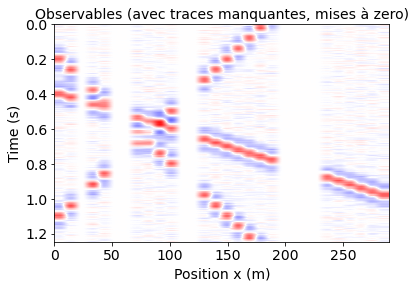

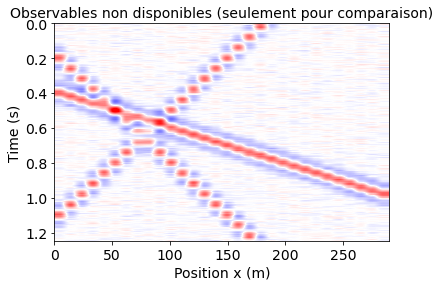

In [10]:
# Display of the input data
vmax    = np.max(np.abs(gpanel))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables (avec traces manquantes, mises à zero)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

fig = plt.figure()
av = plt.subplot(111)
plt.imshow(panel_dense,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables non disponibles (seulement pour comparaison)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

# Première Analyse



* Dans les 2 images plus haut, 3 événements principaux ressortent. Ils sont associés à 3 temps différents (pour $x = 0$ m) et à 3 pentes différentes représentées ici :

<img src="data.png" width="400">

* Nous ferons l'hypothèse que ces événements sont linéaires, c'est-à-dire qu'il est possible de prédire une trace à une position $x$ connaissant les temps $t_i$ à la position $x_0 = 0$ m, les pentes $p_i$ et une fonction $S(t)$ appelee ondelette source  :
$$u(t,x) \simeq \sum_{i=1}^{3} S(t - t_i - p_i(x-x_0))$$

* Quelle est l'unité des pentes $p_i$? Donner les valeurs approximatives de ces 3 pentes $p_i$ et des 3 temps $t_i$.


Les $p_i$ ont pour unité des $s.m^{-1}$. On lit graphiquement :

$p_1=-\frac{0.9-0.4}{300-0}=-1.67 ms.m^{-1}$ et $t_1=0.4 s$

$p_2=-\frac{0.0-1.1}{180-0}=6.11 ms.m^{-1}$ et $t_2=1.1 s$

$p_3=-\frac{1.2-0.2}{170-0}=-5.88 ms.m^{-1}$ et $t_3=0.2 s$


**Aliasing spatial**

Sur l'image suivante, des événements sont visibles à gauche, avec une pente bien visible $p_1$. Sur la partie de droite de l'image, deux pentes sont identifiables $p_2$ et $p_3$. Pourtant on peut suivre des événement de gauche à droite : c'est l'effet d'aliasing spatial.

<img src="aliasing.png" width="400">

Construisez des données comme suit, avec les mêmes échantillonages temporel et spatial que sur l'exemple avec les données manquantes : 
$$d(t,x) = \sin(2 \pi f_c (t - p\cdot x))$$
$f_c$ est la fréquence caractéristique du signal (pour l'obtenir, calculer les spectres de plusieurs traces et déterminer $f_c$ comme valeur pour laquelle le spectre est en moyenne le plus grand). Tracer $d(t,x)$ pour différentes valeurs de $p$, en commençant par $p=0$. La pente visible dans les données augmente avec $p$, jusqu'à un certain moment : c'est l'effet d'aliasing spatial. Est-il possible de retrouver le cas $p=0$ pour un $p$ non nul? A partir des observations, proposer un critère à respecter pour éviter l'aliasing spatial. Ce critère est une relation entre $p$, $f_c$ et la distance $dx$ (ici 10 m) entre 2 traces consécutives. Vérifier si les pentes $p_i$ conduisent ou pas à de l'aliasing spatial.

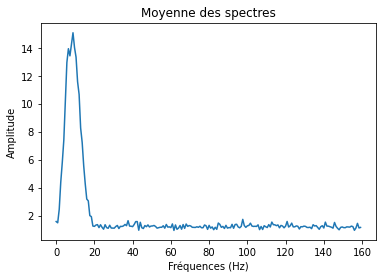

fc =  8.8  Hz


In [11]:
spectres=[]
for i in range(nx):
    fft=np.fft.fft(gpanel[:,i])
    n=fft.shape[0]
    spectres.append(np.abs(fft[:n//2]))
    
spectres=np.array(spectres)
moyenne=np.mean(spectres,axis=0)
frequences=[i/(nt*dt) for i in range(len(moyenne))]
plt.plot(frequences,moyenne)
plt.title("Moyenne des spectres")
plt.xlabel("Fréquences (Hz)")
plt.ylabel("Amplitude")
plt.show()

imax=np.argmax(moyenne)
fc=imax/(nt*dt)
print("fc = ",fc," Hz")

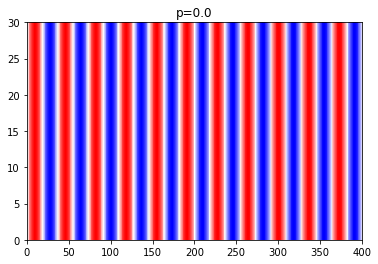

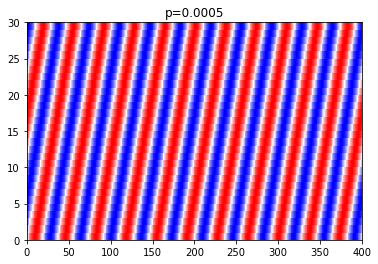

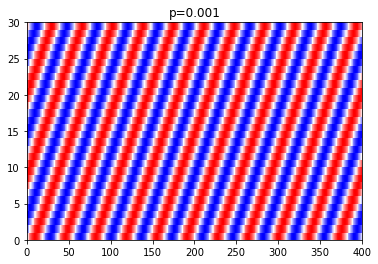

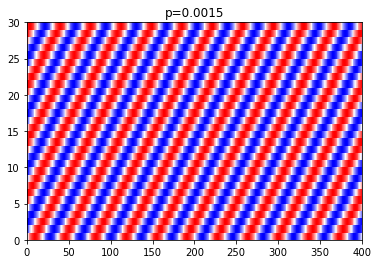

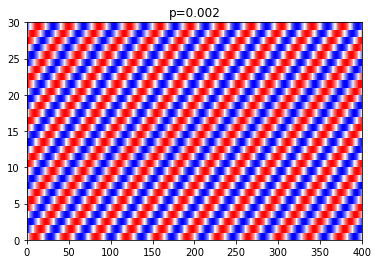

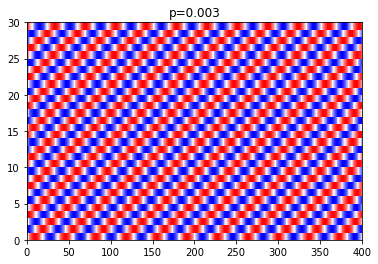

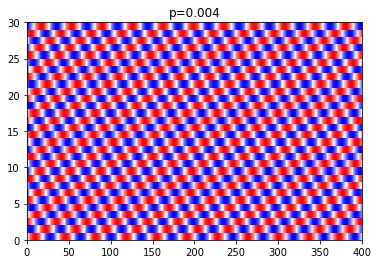

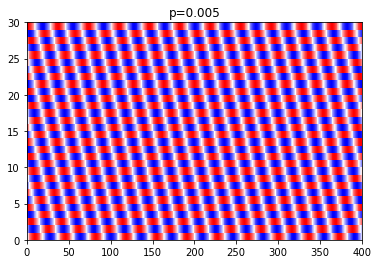

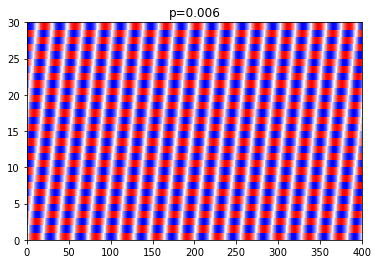

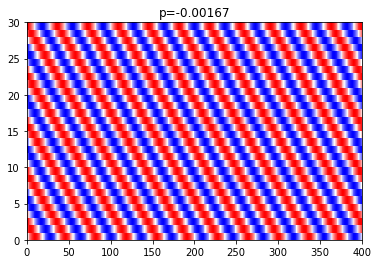

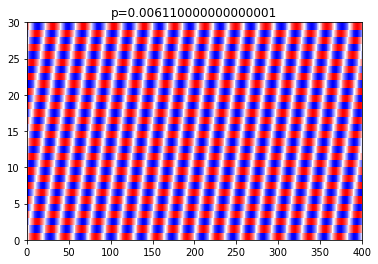

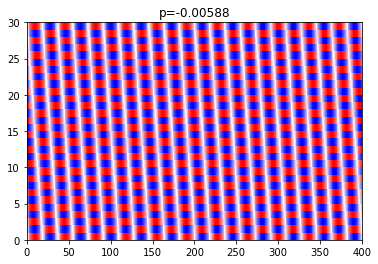

In [12]:
def d(t,x,p):
    return np.sin(2*np.pi*fc*(t-p*x))

val_p=[0,0.5,1,1.5,2,3,4,5,6]
pi=[-1.67,6.11,-5.88]
val_p=[p*0.001 for p in val_p]
pi=[p*0.001 for p in pi]
def plot_d(p):
    Z=np.zeros((nx,nt))
    for i in range(nx):
        for j in range(nt):
            Z[i,j]=d(j*dt,i*dx,p)
    plt.pcolormesh(np.array(Z))
    plt.title(f"p={p}")
    plt.show()

for p in val_p:
    plot_d(p)
for p in pi:
    plot_d(p)


# Approche 1 : Reconstitution des Données dans le Domaine $(x,t)$



## Détermination de $S(t)$

Sélectionner une trace (par exemple pour $x$ autour de 250 m et déterminer $S(t)$ avec l'hypothèse que $S(t)$ est maximale pour $t=0$. Prendre pour le support de $S$ une fenêtre de longueur autour de 0.2 s. Afficher le résultat.

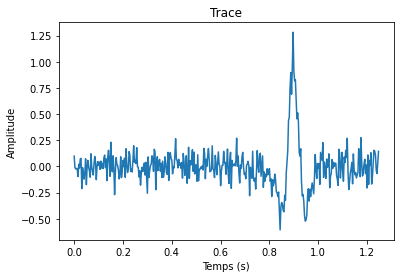

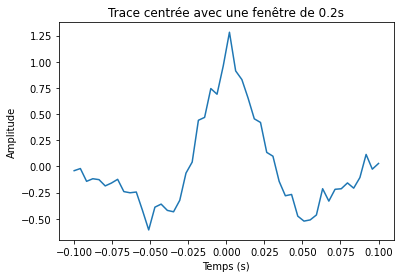

In [13]:
x=250
ix=int(x/dx)
trace=gpanel[:,ix] #on sélectionne une trace
plt.plot(at,trace)
plt.title("Trace")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.show()

imax=np.where(trace == np.amax(trace))
tmax=imax[0][0]*dt #tmax est l'instant où S(t) est maximale
def S(t):
    return trace[int((t+tmax)/dt)] #on décale de tmax pour que le max soit atteint en t=0

T=np.linspace(-0.1,0.1,50)
plt.plot(T,[S(t) for t in T])
plt.title("Trace centrée avec une fenêtre de 0.2s")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.show()


## Détermination des $(t_i,p_i)$

A partir de la première trace en $x_0=0$, calculer pour plusieurs temps et pour plusieurs pentes les sommations suivantes :

$$F(t,p) = \Bigg[\int \,u(t-p\cdot(x-x_0),x)\,dx\Bigg]^2$$

A quoi correspondent les maxima de $F$? En déduire les valeurs de $(t_i,p_i)$ pour $i\in[1,3]$. Bien choisir l'échantillonnage en temps et en pente pour une bonne détermination des $(t_i,p_i)$. 


Les maxima de $F$ correspondent aux $t_i,p_i$. En effet, cela revient à intégrer directement sur une des trois droites, ce qui maximise donc la valeur de $F$.


Remarques :
* Par exemple, il peut être intéressant d'interpoler linéairement entre 2 points voisins si $t - p\cdot(x-x_0)$ ne tombe pas sur un point de grille ;
* Pour une bonne estimation, l'échantillonnage des pentes doit être suffisament fin ;
* Il est possible de reprendre une idée du TP "synthèse musicale" pour sélectionner itérativement les meilleurs $(t_i,p_i)$, mais ici en 2d.

Reconstruire les données à partir de l'équation (1) et des valeurs $(t_i,p_i)$ sélectionnées. Commentez les résultats.

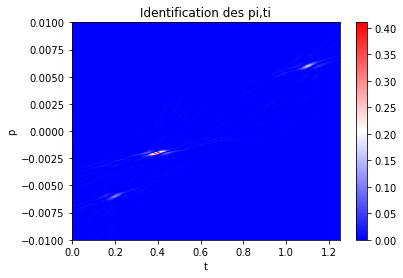

In [173]:
Ti=[0.4,1.1,0.2] #la liste de t_i qu'il faut retrouver
Pi=[1.67*10**-3,-6.11*10**-3,5.88*10**-3] #la liste de p_i qu'il faut retrouver

def u(t,x):
    i=int(t/dt)
    j=int(x/dx)
    return gpanel[i,j]

def F(x0,t,p):
    S=0
    for i in range(nx):
        x=dx*i
        tu=t-p*(x-x0)
        if tu>0 and tu<1.2:
            S+=dt*dx*u(tu,x)
    return S**2

def plot(x0): #on plot, pour une trace donnée, la valeur de F en fonction de t et p
    P=np.linspace(-0.01,0.01,1000)
    T=np.linspace(0,dt*(nt-1),nt)
    Z=np.zeros([len(P),len(T)])
    grx,gry=np.meshgrid(T,P)
    for i in range(len(P)):
        for j in range(len(T)):
            Z[i,j]=F(x0,T[j],P[i])
    c=plt.pcolormesh(grx,gry,np.array(Z))
    plt.colorbar(c)
    plt.xlabel("t")
    plt.ylabel("p")
    plt.title("Identification des pi,ti")
    plt.show()

plot(0)

Trois maximum apparaissent clairement. Ils correspondent aux $(t_i,p_i)$.



On lit gaphiquement : (en zoomant sur le graphique)

- $p_1=-1.7$ $ms/m$  et $t_1=0.4s$
- $p_2=6.5$ $ms/m$ et $t_2=1.2s$
- $p_3=-5.6$ $ms/m$ et $t_3=0.2s$

Ce qui correspond à ce qu'on devait obtenir.

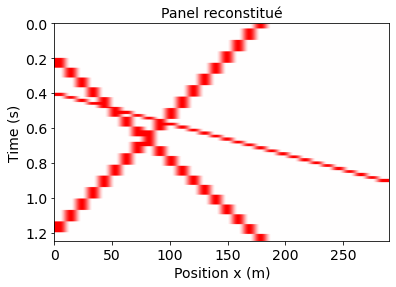

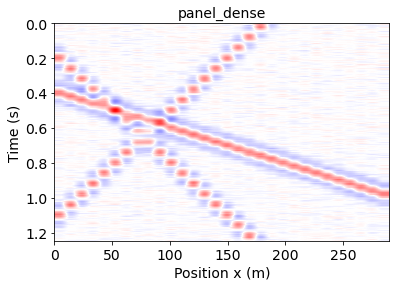

In [169]:
P=[-1.7*10**-3,6.5*10**-3,-5.6*10**-3]
T=[0.4,1.2,0.2]

def construction_panel(P,T):
    new_panel=np.zeros([nt,nx])
    for i in range(len(P)):
        p=-P[i]
        t=T[i]
        if p>0:
            j=int(t/dt)
            while j<nt and int(((j*dt-t)/(dx*p)))<nx and int(((j*dt-t)/(dx*p)))>-nx:
                new_panel[j,int(((j*dt-t)/(dx*p)))]=1
                j+=1
        else :
            j=int(t/dt)
            while j>0 and int((j*dt-t)/(p*dx))>=0:
                new_panel[j,int((j*dt-t)/(p*dx))]=1
                j-=1
    return new_panel


#Pour visualiser plus rapidement les données :
def plot_panel(panel,titre=""):
    vmax    = np.max(np.abs(panel))
    fig = plt.figure()
    av = plt.subplot(111)
    plt.imshow(panel,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
    plt.title(titre, fontsize = labelsize)
    av.set_ylabel("Time (s)", fontsize = labelsize)
    av.set_xlabel("Position x (m)", fontsize = labelsize)
    av.tick_params(axis='both', which='major', labelsize=labelsize)
    plt.clim([-vmax,vmax])
    plt.set_cmap('bwr')
    plt.show()


plot_panel(construction_panel(P,T),"Panel reconstitué")
plot_panel(panel_dense, "panel_dense")
        

On obtient bien quelque chose de semblable à ce que l'on doit obtenir.

# Approche 2 : Analyse des Données dans le Domaine de Fourier 2d



## Approche théorique
Calculer la transformée de Fourier 2d de $u$ à partir de la transformée de Fourier 1d de $S$. Expliquer toujours à partir des équations pourquoi on s'attend à avoir 3 événements linéaires dans le domaine de Fourier. Pourquoi tous ces événements passent-ils par l'origine $(0,0)$ dans le domaine de Fourier? Donner une expression quantitative entre les pentes dans le domaine de Fourier et les pentes $p_i$. 


Calculons la trasformée de Fourier 2d $F(u)$ de $u$:

$u(t,x)=\sum_{i=1}^{3}S(t-t_i-p_i(x-x_0))$

Donc $F(u)(\omega , k)= \int_{x} \int_{t} u(t,x)e^{-i(\omega t + kx )}dtdx$

$=\int_{x} \int_{t} \sum_{i=1}^{3}S(t-t_i-p_i(x-x_0))e^{-i(\omega t + kx )}dtdx$

On effectue le changement de variable dans chaque intégrale : $y=t-t_i-p_i(x-x_0)$

$=\sum_{i=1}^{3} \int_ {x} \int_ {t}S(y)e^{-i(\omega (y+t_i+p_i(x-x_0)) + kx )}dydx$

$=\sum_{i=1}^{3} \int_ {x} e^{-i(\omega (t_i+p_i(x-x_0)) + kx )}\int_ {t}S(y)e^{-i\omega y}dydx$

On reconnait $F(S)$ la transformée de Fourier 1D de $S$ :

$=\sum_{i=1}^{3} \int_ {x} e^{-i(\omega (t_i+p_i(x-x_0)) + kx )}F(S)(\omega)dx$

$=F(S)(\omega)\sum_{i=1}^{3} e^{-i(\omega t_i-\omega p_ix_0)} \int_ {x} e^{-i(\omega p_i+k)x}dx$

On reconnait ici la transformée de Fourier de la fonction constante égale à 1, évaluée en $\omega p_i +k$

Ainsi, 
$F(u)(\omega , k)=F(S)(\omega)\sum_{i=1}^{3} e^{-i(\omega t_i-\omega p_ix_0)} \delta _{0}(\omega p_i +k)$

Pour que la transformée de Fourier soit non nulle, il faut donc que $\omega p_i +k=0$.
On a donc une somme de 3 évènements linéaires et qui passent par $(0,0)$ dans le domaine de Fourier.

$\omega=-k/p_i$, donc les pentes dans le domaine de Fourier correspondent aux $-1/p_i$
On s'attends donc à avoir deux pentes négatives et une pente positive.


## Implémentation
Représenter la transformée de Fourier 2d et bien préciser les axes. Indiquer à quoi correspondent la fréquence maximale et le nombre d'onde maximal. Faire le lien entre les 3 événements dans l'espace $(t,x)$ et ceux dans l'espace de Fourier. Expliquer ce qu'il se passe aux bords dans le domaine de Fourier. N'hesitez pas à zoomer autour de la position centrale dans le domaine de Fourier.

Remarques : 
* Le nombre d'onde (en 1/m) est l'équivalent de la fréquence pour l'axe spatial ;
* Le signal a très peu d'énergie pour les fréquences au-delà de 20 Hz. 

On choisit une fréquence maximale de 20Hz selon les remarques. Le nombre d'onde maximal correpond à 1/dx.

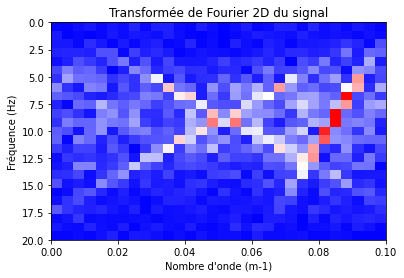

In [15]:
fmax=20 #le signal a peu dénergie a delà de 20Hz
ft = abs(np.fft.fft2(gpanel))[:int(fmax*nt*dt)]
plt.imshow(ft,extent=[0,1/dx,fmax,0], aspect='auto')
plt.xlabel("Nombre d'onde (m-1)")
plt.ylabel("Fréquence (Hz)")
plt.title("Transformée de Fourier 2D du signal")
plt.show()

Aux bords du domaines de Fourier, la transformée "boucle". Par exemple, dans l'image ci-dessus, le bord droit correspond directement au bord gauche. C'est pourquoi les droites qui correspondent à des pentes négatives semblent partir du coin en haut à droite.

## Définition d'un masque dans le domaine de Fourier 2d
On note $f$ la fréquence et $k_x$ le nombre d'onde. Dans le domaine de Fourier 2d, on souhaite définir un masque avec des 1 qui couvrent les événements principaux. A partir de $(f,k_x)=(0,0)$, faire des sommations selon différentes pentes (dans le domaine de Fourier, après avoir pris le module des valeurs complexes) et tracer la valeur de ces sommes en fonction de la pente. On s'attend à ce que 3 valeurs ressortent. Calculer une fonction qui sélectionne automatiquement ces valeurs et construire un masque dans le domaine de Fourier 2d qui vaut 1 autour de ces trois valeurs principales et 0 en dehors.

Comment faire pour prendre en compte ce qui se passe aux bords dans le dommaine de Fourier?

Pour prendre en compte ce qui se passe aux bords du domaine de Fourier, on fait une disjonction de cas suivant le signe de la pente.
Quand elle est positive, on part du coin en haut à gauche, et l'équation est simplement $k=a*f$.
Quand elle est négative, on part du coin en haut à droite, et l'équation est $k=a*f+m-1$ avec m le nombre de colonnes. Cela ne change en réalité rien au code, puisque 
```python
ft[:,-i+m-1]=ft[:,-i]
```

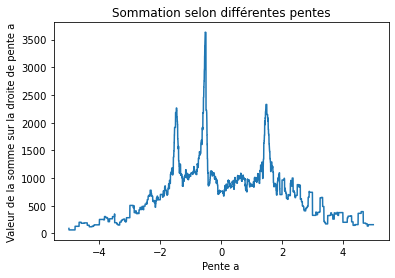

In [16]:
def somme_sur_une_pente(ft,a): #pente a
    S=0
    n,m=np.shape(ft)
    i=0
    while i<n and ((a>0 and int(a*i)<m) or (a<=0 and int(a*i+m-1)>0)) :
        S+=ft[i,int(a*i)] #k=a*f sur la droite de pente a
        i+=1
    return S

def tracer_somme_en_fonction_de_la_pente(ft,n,amin,amax):
    A=[amin+(amax-amin)*k/n for k in range(n)]
    Y=[somme_sur_une_pente(ft,a) for a in A]
    plt.plot(A,Y)
    plt.xlabel("Pente a")
    plt.ylabel("Valeur de la somme sur la droite de pente a")
    plt.title ("Sommation selon différentes pentes")
    plt.show()

tracer_somme_en_fonction_de_la_pente(ft,5000,-5,5)

On observe que effectivement, trois valeurs ressortent pour les pentes. Cela correspond aux trois évènements linéraires que l'on recherche.

In [17]:
def selection_3_max(ft,n,amin,amax,epsilon=0.3):
    A=[amin+(amax-amin)*k/n for k in range(n)]
    Y=[somme_sur_une_pente(ft,a) for a in A]
    #plt.plot(A,Y)
    #plt.show()
    #on trouve le premier max
    imax1=np.argmax(Y)
    #print(A[imax1])
    #on met les valeurs à zéro aux alentours de ce maximum
    nb_valeurs_nulles=int(n*epsilon/(amax-amin))
    for k in range(nb_valeurs_nulles):
        Y[imax1+k]=0
        Y[imax1-k]=0
    #plt.plot(A,Y)
    #plt.show()
    #on cherche le deuxième max
    imax2=np.argmax(Y)
    #print(A[imax2])
    #on met les valeurs à zéro aux alentours de ce maximum
    nb_valeurs_nulles=int(n*epsilon/(amax-amin))
    for k in range(nb_valeurs_nulles):
        Y[imax2+k]=0
        Y[imax2-k]=0
    #plt.plot(A,Y)
    #plt.show()
    #on cherche le dernier max
    imax3=np.argmax(Y)
    #print(A[imax3])
    return A[imax1],A[imax2],A[imax3]

print("Les trois maximums choisis sont : ")
selection_3_max(ft,5000,-5,5)

Les trois maximums choisis sont : 


(-0.5220000000000002, 1.4740000000000002, -1.4700000000000002)

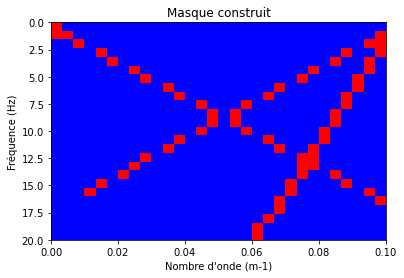

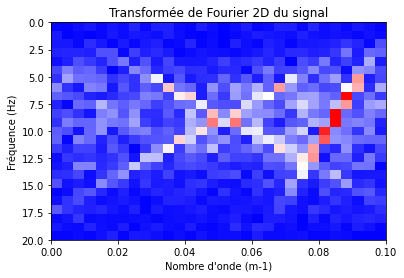

In [18]:
def construction_masque(ft,n,amin,amax):
    a1,a2,a3=selection_3_max(ft,n,amin,amax)
    n,m=np.shape(ft)
    masque=np.zeros([n,m])
    for a in [a1,a2,a3]:
        i=0
        while i<n and ((a>0 and int(a*i)<m) or (a<=0 and int(a*i+m-1)>0)) :
            masque[i,int(a*i)]=1 #k=a*f sur la droite de pente a
            i+=1
    return masque
    
masque=construction_masque(ft,5000,-5,5)
plt.imshow(masque,extent=[0,1/dx,fmax,0], aspect='auto')
plt.xlabel("Nombre d'onde (m-1)")
plt.ylabel("Fréquence (Hz)")
plt.title("Masque construit")
plt.show()

plt.imshow(ft,extent=[0,1/dx,fmax,0], aspect='auto')
plt.xlabel("Nombre d'onde (m-1)")
plt.ylabel("Fréquence (Hz)")
plt.title("Transformée de Fourier 2D du signal")
plt.show()

Le masque correspond bien à la transformée de Fourier

## Application du masque et analyse des résultats
Appliquer le masque (sur les données après transformée de Fourier 2d, sans prendre le module des valeurs), puis appliquer la transformée de Fourier inverse. Commenter les résultats (comparaison à la fois dans les domaines $(t,x)$ et $(f,k_x)$. Si nécessaire, revenir à la question précédente pour changer le masque et avoir une meilleure interpolation des données. Expliquer ces changements. Discuter de l'importance du masque.

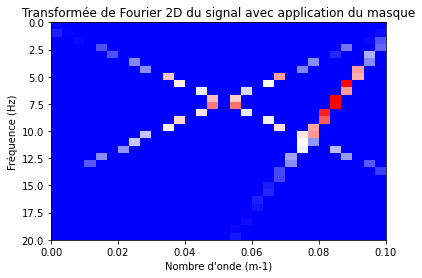

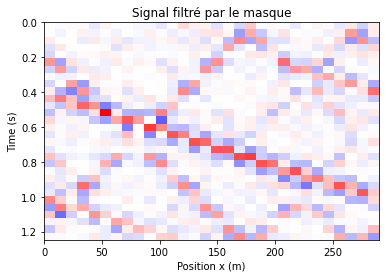

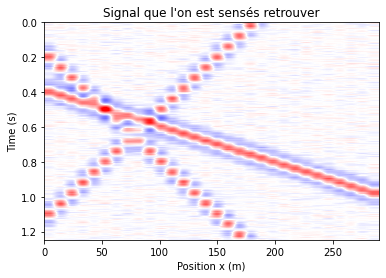

In [22]:
ft=np.fft.fft2(gpanel)[:30]
masque=construction_masque(abs(ft),5000,-5,5)
ft=ft*masque

plt.imshow(abs(ft),extent=[0,1/dx,fmax,0], aspect='auto')
plt.xlabel("Nombre d'onde (m-1)")
plt.ylabel("Fréquence (Hz)")
plt.title("Transformée de Fourier 2D du signal avec application du masque")
plt.show()

new_panel=np.fft.ifft2(ft).real
vmax = np.max(np.abs(new_panel))
plt.imshow(new_panel,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Signal filtré par le masque')
plt.ylabel("Time (s)")
plt.xlabel("Position x (m)")
plt.clim([-vmax,vmax])
plt.show()

vmax = np.max(np.abs(gpanel))
plt.imshow(panel_dense,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title("Signal que l'on est sensés retrouver")
plt.ylabel("Time (s)")
plt.xlabel("Position x (m)")
plt.clim([-vmax,vmax])
plt.show()


On obtient un résultat très bruyant et peu lisible.

Une manière de modifier le masque pour avoir un meilleur résultat est de prendre des droites plus larges. Ici, on rajoute à chaque fois les cases d'au dessus et d'en dessous pour avoir un meilleur résultat :

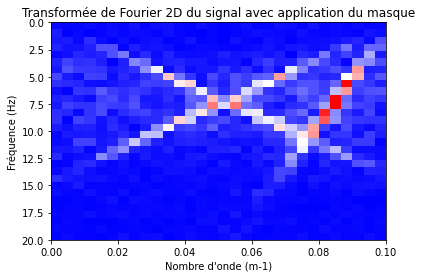

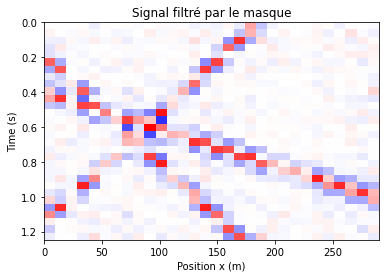

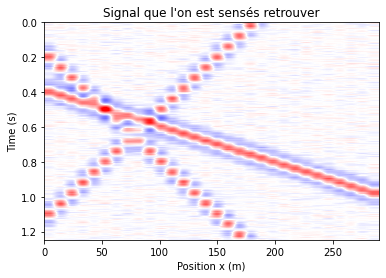

In [176]:
def construction_masque_large(ft,n,amin,amax):
    a1,a2,a3=selection_3_max(ft,n,amin,amax)
    n,m=np.shape(ft)
    masque=np.zeros([n,m])
    for a in [a1,a2,a3]:
        i=0
        while i<n and ((a>0 and int(a*i)+1<m) or (a<=0 and int(a*i+m-2)>0)) :
            masque[i,int(a*i)]=1 #k=a*f sur la droite de pente a
            masque[i,int(a*i)+1]=1
            masque[i,int(a*i)-1]=1
            i+=1
    return masque


ft=np.fft.fft2(gpanel)[:30]
masque=construction_masque_large(abs(ft),5000,-5,5)
masque=0.5*masque+0.5
ft=ft*masque
plt.imshow(abs(ft),extent=[0,1/dx,fmax,0], aspect='auto')
plt.xlabel("Nombre d'onde (m-1)")
plt.ylabel("Fréquence (Hz)")
plt.title("Transformée de Fourier 2D du signal avec application du masque")
plt.show()

new_panel=np.fft.ifft2(ft).real
vmax = np.max(np.abs(new_panel))
plt.imshow(new_panel,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Signal filtré par le masque')
plt.ylabel("Time (s)")
plt.xlabel("Position x (m)")
plt.clim([-vmax,vmax])
plt.show()

vmax = np.max(np.abs(gpanel))
plt.imshow(panel_dense,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title("Signal que l'on est sensés retrouver")
plt.ylabel("Time (s)")
plt.xlabel("Position x (m)")
plt.clim([-vmax,vmax])
plt.show()

On obtient en effet un résultat plus lisse et qui ressemble plus au résultat fourni.

Le masque permet de ne garder que les trois évênements linéaires dans la transformée de Fourier. Cela ne prend donc en compte que les 3 droites. Le reste de la transformée de Fourier est du à l'absence des données pour certaines traces, et au bruit. Cela permet donc de compléter les traces vides.

# Approche 3 : Amélioration de l'Approche 2 (*partie optionelle*)


Le résultat de l'approche 2 montre en pratique que les données prédites après transformée de Fourier inverse 2d ne calent pas parfaitement aux données observées (pour les traces non nulles). C'est un inconvénient, mais d'un autre côté, ceci offre la possibilité d'aller plus loin pour forcer un bon calage.

Pour cela, nous définissons une fonction objective

$$
J[p] = \frac{1}{2}||T p - p^\mathrm{obs}||_2^2 + \frac{\alpha}{2} || F p ||_M^2
$$

ou $p(t,x)$ sont les signaux (sur toutes les traces), $T$ l'operateur qui vaut 1 pour des traces existantes et 0 sinon, $p^\mathrm{obs}(t,x)$ les observables (i.e. pour les traces non nulles), $F$ la transformee de Fourier 2d. La norme $||p||_2^2 = \sum_x \sum_t |p(t,x)|^2$ et $||q||_M^2= \sum_x \sum_t M(f,k_x)|q(f,k_x)|^2$, avec $M$ un masque défini dans le domaine de Fourier. Le poids $\alpha$ est une pondération entre les deux termes.

On cherche à minimiser $J$. Le meilleur $p$ sera celui qui minimise l'écart aux données (premier terme) tout en minimisant l'énergie dans le domaine de Fourier 2d (avec présence du masque). Par rapport au masque $M_0$ des questions 2 et 3, on prend ici $M=1 - M_0$. Expliquer pourquoi.

La minimisation se fait de manière itérative, avec la fonction ```minimize``` de scipy (```from scipy.optimize import minimize```). Parmi plusieurs possibilités, je suggère de prendre une approche de gradient conjugué (CG). La minisation va se faire selon :

```
res = minimize(defj, p0, method='CG', jac=defg, \
        options={'disp': True, 'maxiter':niter})
```

Il faut donc créer une valeur initiale pour $p$ (ici ```p0```), spécifier le nombre d'itérations ```niter``` et surtour définir la fonction objective ```defj()``` et son gradient par rapport à $p$ ```defg()```.

Le gradient est donné par 

$$
\frac{\partial J}{\partial p} = T^t(T p - p^\mathrm{obs}) + \alpha F^t M F p
$$

où $^t$ est l'opérateur transposé. L'application de $T^t$ correspond donc à insérer des traces nulles là où il n'y a pas d'observables et $F^t$ est la transformée de Fourier inverse.

Construire les fonctions ```defj()``` et ```defg()```. Attention, ```minimize``` attend que ```p``` soit sous forme de vecteur. On peut donc utiliser ```np.transpose(p,nt*nx)``` (voir plus bas dans l'exemple).

$\alpha$ est une pondération dont la valeur est à tester.

La valeur initiale ```p0``` de $p$ peut être prise égale à ```gpanel``` (le tableau lu au debut du code).

Faire plusieurs itérations. Analyser les résultats à la fois dans le domaine temporel et dans le domaine de Fourier 2d. Etudier l'importance de la régulariation.

In [ ]:
# Exemple de structure du code
def defj(p):
    """Definition of the objective function"""
    # Retrieve the size
    pan = np.reshape(p,[nt,nx])
    j0  = 0.
    #
    # ADD
    #
    return j0
    
    
def defg(p):
    """Definition of the gradient of the objective function"""
    # Retrieve the size
    pan = np.reshape(p,[nt,nx])
    grd = np.zeros([nt,nx])
    #
    # ADD
    #
    # Return with vector size
    return np.reshape(grd,nt*nx)

In [ ]:
# Iterative mininisation (example)
niter = 10 # number of iterations
p0 = np.reshape(np.copy(gpanel),nt*nx)
res = minimize(defj, p0, method='cg', \
                jac=defg, \
                options={'disp': True, 'maxiter':niter})
# Final panel
panelf = np.reshape(res.x,[nt,nx])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


# Analyse des Limites des Approches
Proposer une analyse des avantages et limites des approches 1, 2 (et 3 le cas échéant). Tester la robustesse au travers de d'autres applications. Par exemple, vous pouvez :
* Ajouter du bruit (gaussien ou non) sur les données ;
* Avoir des événements linéaires avec des amplitudes différentes ;
* Ajouter des délais en temps pour chaque position en $x$ et comparer les résultats ;
* Rnlever encore plus de données en entrée (plus de traces blanches) ;
* Application sur des images totalement différentes.

**Cette dernière partie est très ouverte, et je fais appel à votre créativité.**

Tout d'abord, il faut remarquer que la seconde approche est plus simple à implémenter, et aussi plus automatisée (on n'a pas besoin de lire graphiquement les $p_i,t_i$. Elle est aussi moins gourmande en temps de calcul.

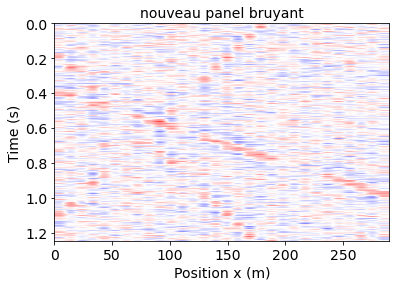

Testons la première approche sur ce panel :


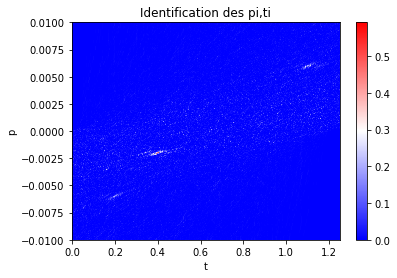

In [188]:
#ajoutons du bruit :
from random import gauss
def panel_bruyant(gpanel,amplitude):
    nt, nx = gpanel.shape
    new_panel=np.zeros([nt,nx])
    for i in range(nt):
        for j in range(nx):
            new_panel[i,j]=gpanel[i,j]+amplitude*gauss(0,1)
    return new_panel

plot_panel(panel_bruyant(gpanel,0.6),"nouveau panel bruyant")

#1ère approche
def test_premiere_approche(panel):
    print("Testons la première approche sur ce panel :")
    
    def u(t,x):
        i=int(t/dt)
        j=int(x/dx)
        return panel[i,j]
    def F(x0,t,p):
        S=0
        for i in range(nx):
            x=dx*i
            tu=t-p*(x-x0)
            if tu>0 and tu<1.2:
                S+=dt*dx*u(tu,x)
        return S**2
    def plot(x0): #on plot, pour une trace donnée, la valeur de F en fonction de t et p
        P=np.linspace(-0.01,0.01,1000)
        T=np.linspace(0,dt*(nt-1),nt)
        Z=np.zeros([len(P),len(T)])
        grx,gry=np.meshgrid(T,P)
        for i in range(len(P)):
            for j in range(len(T)):
                Z[i,j]=F(x0,T[j],P[i])
        c=plt.pcolormesh(grx,gry,np.array(Z))
        plt.colorbar(c)
        plt.xlabel("t")
        plt.ylabel("p")
        plt.title("Identification des pi,ti")
        plt.show()
    plot(0)

test_premiere_approche(panel_bruyant(gpanel,0.6)) 


On retrouve les mêmes résultats. La première approche fonctionne aussi avec du bruit. Même avec une amplitude très élevée (jusqu'à 0.6, cela marche encore!), il est encore possible d'identifier les $p_i,t_i$.

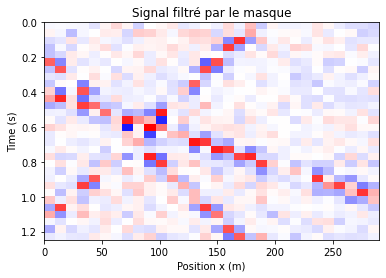

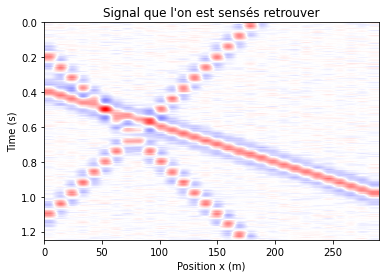

In [182]:
#2ère approche
def test_deuxieme_approche(panel):
    ft=np.fft.fft2(panel)[:30]
    masque=construction_masque_large(abs(ft),5000,-5,5)
    masque=0.5*masque+0.5
    ft=ft*masque
    new_panel=np.fft.ifft2(ft).real
    vmax = np.max(np.abs(new_panel))
    plt.imshow(new_panel,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
    plt.title('Signal filtré par le masque')
    plt.ylabel("Time (s)")
    plt.xlabel("Position x (m)")
    plt.clim([-vmax,vmax])
    plt.show()

    vmax = np.max(np.abs(panel_dense))
    plt.imshow(panel_dense,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
    plt.title("Signal que l'on est sensés retrouver")
    plt.ylabel("Time (s)")
    plt.xlabel("Position x (m)")
    plt.clim([-vmax,vmax])
    plt.show()

test_deuxieme_approche(panel_bruyant(gpanel,0.2)) 

Encore une fois, la seconde approche fonctionne bien même avec un peu bruit. Cependant, dès que celui ci augmente, la méthode ne résiste plus, et le résultat obtenu est illisible. (Cela ne marche plus au delà d'une amplitude de 0.2)

Ainsi, la première approche résiste mieux au bruit